In [95]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

# LOAD FROM SCIKIT-LEARN
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse

In [62]:
# Load in sentiment and price data, and rename Date_Hour to match the 'Open time' column for merging with price df  
senti_df = pd.read_csv('twitter_73_days_sentiment_NLKT_per_hour.csv', encoding='utf-8')
price_df = pd.read_csv('price_ML_data.csv', encoding='utf-8')
senti_df['Open time'] = senti_df['Date_Hour'] 

# Merging Twitter data and Price Data
ML_df = pd.merge(senti_df, price_df, how='inner', on= 'Open time')

In [81]:
# Defining the X and Y variables
SF = ML_df['Sum']
CP = ML_df['Close']
VOL= ML_df['Vol']
#Ydata
PC = ML_df['Percentage change']



# Choose which ones to apply to ML model         (Choose wisely.....)
Xdata = np.array([VOL, SF])
Ydata = np.array(CP)



In [82]:
# LOAD SCIKIT LEARN DATA
#from sklearn.datasets import load_boston
#boston = load_boston()

# PRINT VARIABLES FROM DESCRIPTION FOR ILLUSTRATION
# print(boston['DESCR'])
#print('\n'.join(load_boston()['DESCR'].split('\n')[12:26]))

# DEFINE FEATURES AND TARGET AND SPLIT INTO TRAIN/TEST
X = Xdata.T # features
y = Ydata # target 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, train_size=0.5, random_state=161193)

In [83]:
# DEFINE A PIPELINE (already did that...)
pipe = make_pipeline(PolynomialFeatures(degree = 2), 
                             StandardScaler(),
                             LinearRegression()) #need to specify in correct order

# Fit and evaluate model
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [84]:
# TWO TYPES OF TRANSFORMATIONS
poly_trans = PolynomialFeatures()
sc = StandardScaler()

# APPLY POLYNOMIAL TRANSFORMATION
X_train_poly = poly_trans.fit_transform(X_train) 
X_test_poly = poly_trans.transform(X_test)

# ... AND THEN SCALER
X_train_prep_alt = sc.fit_transform(X_train_poly)
X_test_prep_alt = sc.transform(X_test_poly)

#... And then we fit and evaulate as always

In [85]:
# SPLIT INTO DEVELOPMENT (2/3) AND TEST DATA (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=161193)

# SPLIT DEVELOPMENT INTO TRAIN (1/3) AND VALIDATION (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=161193)

In [86]:
# LOAD DATA FROM SCIKIT-LEARN
#from sklearn.linear_model import Lasso, LinearRegression

# DEFINE PIPELINE
pipe_lr = make_pipeline(PolynomialFeatures(), 
                        StandardScaler(),
                        LinearRegression())

# FIT PIPELINE TO DEVELOPMENT DATA
pipe_lr.fit(X_dev, y_dev)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [87]:
# LOAD DATA FROM SCIKIT-LEARN
#from sklearn.metrics import mean_squared_error as mse

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(-4, 4, 66) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=161193))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_pred, y_val))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

Optimal lambda: 0.00023400803470013468
Validation MSE: 0.001


In [88]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_lasso = make_pipeline(PolynomialFeatures(), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_lasso.fit(X_dev, y_dev) 

# COMPARE MODEL PERFORMANCE ON TEST DATA
print('Lasso', round(mse(pipe_lasso.predict(X_test),y_test), 2))
print('LinReg', round(mse(pipe_lr.predict(X_test),y_test), 2))

Lasso 0.0
LinReg 0.0


In [89]:
# SETUPa
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))

# Outer loop: lambdas
mseCV = []
for lambda_ in lambdas:    
    
    # Inner loop: folds
    mseCV_ = []    
    for train_idx, val_idx in folds:        
        
        # Train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=2, include_bias=True),
                                     StandardScaler(),
                                     Lasso(alpha=lambda_, random_state=161193))            
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx] 
        pipe_lassoCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))    
        
    # Store result    
    mseCV.append(mseCV_) 
    
# Convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)

In [90]:
# CHOOSE OPTIMAL HYPERPARAMETERS (mean of MSE's across folds)
optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)

# RETRAIN/RE-ESTIMATE MODEL USING OPTIMAL HYPERPARAMETERS AND COMPARE PERFORMANCE
pipe_lassoCV = make_pipeline(PolynomialFeatures(include_bias=False), 
                             StandardScaler(),
                             Lasso(alpha=optimal_lambda.index[0], random_state=161193))

pipe_lassoCV.fit(X_dev,y_dev) #fit optimal lambda to entire development set: likely to improve performance slightly since we use more oberservations

models = {'Lasso': pipe_lasso, 'Lasso CV': pipe_lassoCV, 'LinReg': pipe_lr}
for name, model in models.items():
    score = mse(model.predict(X_test),y_test)
    print(name, round(score, 2))

Lasso 0.0
Lasso CV 0.0
LinReg 0.0


In [91]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lasso,
                   X=X_dev,
                   y=y_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=10)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))

mse_.head(5)

,Train,Test
sample size,,
50,0.001131,0.003318
101,0.001171,0.001475
151,0.001240,0.001380
202,0.001263,0.001380
253,0.001244,0.001353


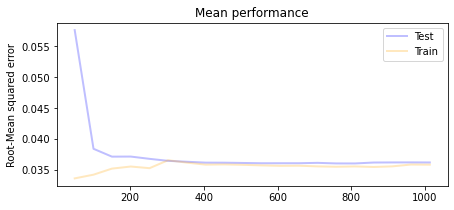

In [92]:
f_learn, ax = plt.subplots(figsize=(7,3))
ax.plot(train_sizes,np.sqrt(-test_scores.mean(1)), alpha=0.25, linewidth=2, label ='Test', color='blue') # negated, because we already use neg_MSE
ax.plot(train_sizes,np.sqrt(-train_scores.mean(1)), alpha=0.25, linewidth=2, label='Train', color='orange') # negated, because we already use neg_MSE

ax.set_title('Mean performance')
ax.set_ylabel('Root-Mean squared error')
ax.legend();

In [93]:
# LOAD FROM SCIKIT-LEARN
from sklearn.model_selection import validation_curve

# FIT AND EVALUATE FOR DIFFERENT LAMBDAS
train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha', #built-in name of hyperparameter
                     param_range=lambdas, #values to consider
                     scoring='neg_mean_squared_error',                 
                     cv=10)

# OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST
mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))


lambda
0.000133    0.001308
Name: Validation, dtype: float64


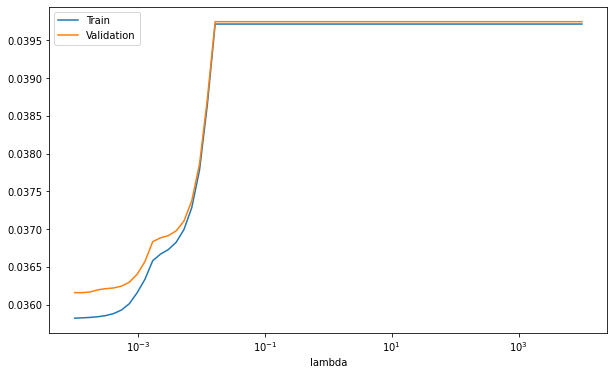

In [96]:
np.sqrt(mse_score).plot(logx=True, figsize=(10,6));